In [438]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt

# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Repo root already in sys.path.


In [439]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    df = pd.DataFrame(data)
    df.columns = df.columns.droplevel(1)
    return df

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [440]:
data = fetch_data('SPY', '2015-01-01', '2025-07-08')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_19864\1736392114.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [441]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'] > 0, 1, -1)
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].shift(-1)  
data.dropna()
data = data.drop(columns=['High','Low','Open','Volume'])  
raw_data = data.copy()
data.dropna(inplace=True)  
data.tail(5)


Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Date,,,,,,,,,,,,,,,,
2025-06-27,614.909973,601.389893,598.693038,69.373928,68.391896,612.911016,585.016236,7.985536,7.483408,0.004968,0.004208,0.007824,0.000560,0.011047,12.939575,1.0
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1.0
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1.0
2025-07-03,625.340027,607.064144,605.934772,74.716437,73.148878,624.667921,584.676116,9.848618,8.530299,0.007881,0.002954,0.004533,-0.000324,0.004781,29.661011,-1.0


In [442]:
from courselib.utils.normalization import standardize
from courselib.utils.splits import train_test_split
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.7, class_column_name='Daily_Return_Sign',shuffle = False,return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)
X_train, Y_train

(array([[-1.18320567, -1.14664106, -1.14232574, ..., -1.17462138,
         -1.20565047, -0.09339807],
        [-1.15799605, -1.14823209, -1.14318576, ...,  0.76982003,
         -1.17341986, -0.10640406],
        [-1.1281932 , -1.14673669, -1.14110624, ..., -1.1526517 ,
          0.77026424,  0.12488509],
        ...,
        [ 1.43543496,  1.68992551,  1.72476891, ..., -0.57057198,
         -3.17445951, -1.93866777],
        [ 1.36149574,  1.64938347,  1.69243322, ..., -2.86579679,
         -0.56960572, -2.735733  ],
        [ 1.35671455,  1.61371023,  1.66271866, ...,  0.15896606,
         -2.86393658, -3.89788927]]),
 array([ 1.,  1., -1., ..., -1., -1.,  1.]))

In [443]:
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=0.5)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 20000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [444]:
svm.w, svm.b

(array([ 0.00091369,  0.00130068,  0.00128839, -0.00572327, -0.00597107,
         0.00112694,  0.00152483,  0.00063861,  0.00169648, -0.01560349,
         0.00202389,  0.00613668, -0.00610075, -0.00189542, -0.00431551]),
 array(0.09972752))

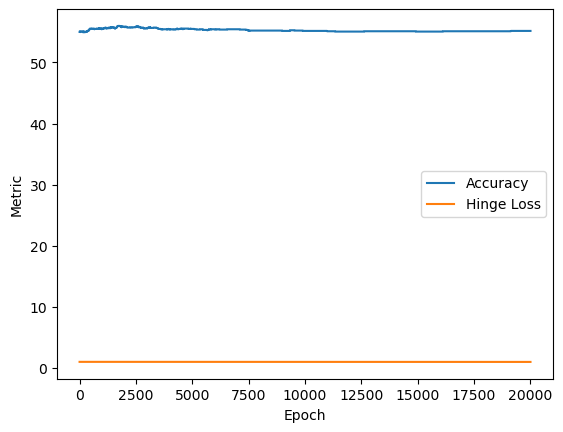

In [445]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [446]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 54.637865311308765


In [447]:
from courselib.models.svm import BinaryKernelSVM
rbf_svm = BinaryKernelSVM(kernel='rbf',sigma = 0.5)
metrics_history = rbf_svm.fit(X_train,Y_train)
binary_acc = binary_accuracy(rbf_svm(X_train), Y_train)
binary_acc


96.73024523160763

In [448]:
y_pred_test = rbf_svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)
y_train_pred = rbf_svm(X_train)

Test Accuracy: 55.90851334180432


In [449]:
data['Daily_Return_Sign'] = data['Daily_Return_Sign'].replace({-1: 0})
data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Date,,,,,,,,,,,,,,,,
2015-01-30,166.573730,169.063644,169.370525,23.546472,39.839108,172.828012,165.551783,-0.636623,-0.474062,-0.012575,0.010508,0.009243,-0.012824,-0.013190,0.359100,1.0
2015-02-02,168.636581,168.933916,169.300626,28.786968,48.509420,172.510198,165.576450,-0.616111,-0.502472,0.012384,0.013018,-0.012575,0.009243,-0.012824,0.242157,1.0
2015-02-03,171.075287,169.055847,169.469641,34.475899,55.141664,172.743999,165.603218,-0.398479,-0.481673,0.014461,0.013672,0.012384,-0.012575,0.009243,2.321793,0.0
2015-02-04,170.423843,169.166090,169.560518,33.705262,56.060591,172.791581,165.909745,-0.275395,-0.440418,-0.003808,0.011650,0.014461,0.012384,-0.012575,0.818466,1.0
2015-02-05,172.144333,169.458957,169.806595,37.649067,63.335903,173.162797,165.856728,-0.038577,-0.360049,0.010095,0.011753,-0.003808,0.014461,0.012384,0.016708,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,614.909973,601.389893,598.693038,69.373928,68.391896,612.911016,585.016236,7.985536,7.483408,0.004968,0.004208,0.007824,0.000560,0.011047,12.939575,1.0
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,0.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1.0


In [450]:
from courselib.models.glm import LogisticRegression
from courselib.utils.metrics import cross_entropy
training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', shuffle=False, return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true, class_labels=[0, 1]), 
                "loss": lambda y_pred, y_true: cross_entropy(y_pred, y_true)}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([-0.00947137, -0.00813001, -0.00816982, -0.01222446, -0.01929671,
        -0.01173987, -0.00390047,  0.00978123,  0.01480556, -0.06462781,
        -0.01746409,  0.01373577, -0.01681715, -0.04006179, -0.0045763 ]),
 array(0.11440784))

In [451]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test, class_labels=[0, 1])
print("Test Accuracy:", test_acc)

Test Accuracy: 57.25190839694656


In [452]:

def pca_numpy(X: np.ndarray, n_components: int = 2):
    """
    Perform PCA using numpy.

    Parameters:
    -----------
    X : np.ndarray
        The input data matrix, shape (n_samples, n_features).
    n_components : int
        Number of principal components to keep.

    Returns:
    --------
    X_reduced : np.ndarray
        The projected data onto top principal components.
    explained_variance_ratio : np.ndarray
        Percentage of variance explained by each selected component.
    components : np.ndarray
        The eigenvectors (principal axes).
    """
    # 1) Center the data
    X_meaned = X - np.mean(X, axis=0)

    # 2) Covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)

    # 3) Eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # 4) Sort eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_index]
    eigen_vectors = eigen_vectors[:, sorted_index]

    # 5) Select top k eigenvectors
    eigenvector_subset = eigen_vectors[:, 0:n_components]

    # 6) Project the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # 7) Explained variance ratio
    explained_variance_ratio = eigen_values / np.sum(eigen_values)

    return X_reduced, explained_variance_ratio[:n_components], eigenvector_subset


In [453]:
X_reduced, explained_var, components = pca_numpy(X, n_components=5)
X_reduced, explained_var, components

(array([[ 3.44613591,  1.33492047, -1.53778603,  0.24554208,  0.94766573],
        [ 3.25567566,  0.77883505,  1.41690862,  1.45347523, -0.1940357 ],
        [ 3.01300753,  0.09948442, -0.18291665, -1.48484748, -0.86049081],
        ...,
        [-6.03033896, -1.15772742, -0.49505594,  0.13372508,  0.01338743],
        [-6.24524905, -1.61201072,  0.07691988,  0.30976817, -0.25280453],
        [-6.4484909 , -1.98839619,  0.02408157, -0.17873639, -0.29631007]]),
 array([0.34853043, 0.26829545, 0.08807177, 0.08127758, 0.06496503]),
 array([[-4.16726666e-01,  1.48545843e-01,  2.82993249e-02,
         -3.18914238e-02,  4.89328113e-03],
        [-4.10433726e-01,  1.71221700e-01,  1.12817813e-02,
         -1.38832871e-02,  1.92208532e-03],
        [-4.09553417e-01,  1.73285067e-01,  1.72231999e-02,
         -2.15523069e-02,  3.39254019e-03],
        [-1.48496769e-01, -4.20790094e-01,  1.11469794e-01,
         -1.20188955e-01,  3.61207413e-02],
        [-1.24615449e-01, -3.99226603e-01,  1.266

In [454]:
split_idx = int(round(0.8 * len(data)))
test_indices = data.index[split_idx:]
y_test_pred = rbf_svm(X_test)

raw_data['rbf_svm_pred'] = np.nan
raw_data.loc[test_indices, 'rbf_svm_pred'] = y_test_pred
raw_data
# For another model, e.g. RBF SVM
#data['rbf_svm_pred'] = np.nan
#data.loc[test_indices, 'rbf_svm_pred'] = rbf_y_pred_test  # replace with your variable

# For logistic regression
#data['logreg_pred'] = np.nan
#data.loc[test_indices, 'logreg_pred'] = logreg_y_pred_test  # replace with your variable

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Date,,,,,,,,,,,,,,,,,
2015-01-02,171.568054,NaN,171.568054,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-05,168.469604,NaN,171.272964,0.000000,NaN,NaN,NaN,-0.247170,-0.049434,-0.018060,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-06,166.882751,NaN,170.854848,0.000000,NaN,NaN,NaN,-0.564591,-0.152465,-0.009419,NaN,-0.018060,NaN,NaN,NaN,1.0,NaN
2015-01-07,168.962341,NaN,170.674610,4.721291,NaN,NaN,NaN,-0.640956,-0.250163,0.012461,NaN,-0.009419,-0.018060,NaN,NaN,1.0,NaN
2015-01-08,171.960541,NaN,170.797079,11.197654,NaN,NaN,NaN,-0.454309,-0.290993,0.017745,NaN,0.012461,-0.009419,-0.018060,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1.0,1.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1.0,1.0
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1.0,-1.0


In [455]:
#raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].replace(-1, 0)
raw_data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred
Date,,,,,,,,,,,,,,,,,
2015-01-02,171.568054,NaN,171.568054,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-05,168.469604,NaN,171.272964,0.000000,NaN,NaN,NaN,-0.247170,-0.049434,-0.018060,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
2015-01-06,166.882751,NaN,170.854848,0.000000,NaN,NaN,NaN,-0.564591,-0.152465,-0.009419,NaN,-0.018060,NaN,NaN,NaN,1.0,NaN
2015-01-07,168.962341,NaN,170.674610,4.721291,NaN,NaN,NaN,-0.640956,-0.250163,0.012461,NaN,-0.009419,-0.018060,NaN,NaN,1.0,NaN
2015-01-08,171.960541,NaN,170.797079,11.197654,NaN,NaN,NaN,-0.454309,-0.290993,0.017745,NaN,0.012461,-0.009419,-0.018060,NaN,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1.0,1.0
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1.0,1.0
2025-07-02,620.450012,605.347306,603.892113,72.221941,71.745537,621.082710,585.144670,9.265255,8.200720,0.004533,0.002937,-0.000324,0.004781,0.004968,24.681213,1.0,-1.0


In [456]:
raw_data['rbf_svm_pred'] = raw_data['rbf_svm_pred'].shift(1)
raw_data.dropna(inplace=True)
raw_data['strategy_return'] = raw_data['Daily_Return'] * raw_data['rbf_svm_pred']
raw_data['cumulative_strategy'] = (1 + raw_data['strategy_return']).cumprod()
raw_data['cumulative_asset'] = (1 + raw_data['Daily_Return']).cumprod()


In [457]:
raw_data

Price,Close,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Daily_Return,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign,rbf_svm_pred,strategy_return,cumulative_strategy,cumulative_asset
Date,,,,,,,,,,,,,,,,,,,,
2023-06-02,415.282867,404.642625,404.326791,65.878144,68.931136,412.422955,394.581690,3.196202,2.364466,0.014461,0.008608,0.009501,-0.005545,0.000381,8.433350,-1.0,1.0,0.014461,1.014461,1.014461
2023-06-05,414.487061,405.646090,405.294435,64.592288,66.564754,414.251164,394.157750,3.609976,2.613568,-0.001916,0.008321,0.014461,0.009501,-0.005545,8.229584,1.0,1.0,-0.001916,1.012517,1.012517
2023-06-06,415.389648,406.617857,406.255884,65.412664,71.842757,415.998416,393.894345,3.965019,2.883858,0.002178,0.008197,-0.001916,0.014461,0.009501,8.967224,-1.0,1.0,0.002178,1.014722,1.014722
2023-06-07,413.953308,407.672434,406.988972,62.926775,65.214962,417.055096,394.353544,4.083422,3.123771,-0.003458,0.007641,0.002178,-0.001916,0.014461,12.092041,1.0,1.0,-0.003458,1.011213,1.011213
2023-06-08,416.457123,408.571735,407.890701,65.383788,63.834438,418.543879,394.444689,4.329387,3.364894,0.006049,0.007179,-0.003458,0.002178,-0.001916,17.507294,1.0,1.0,0.006049,1.017330,1.017330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,614.909973,601.389893,598.693038,69.373928,68.391896,612.911016,585.016236,7.985536,7.483408,0.004968,0.004208,0.007824,0.000560,0.011047,12.939575,1.0,1.0,0.004968,1.458086,1.502114
2025-06-30,617.849976,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.004781,0.003899,0.004968,0.007824,0.000560,22.609680,-1.0,1.0,0.004781,1.465058,1.509296
2025-07-01,617.650024,604.070797,602.149177,70.675784,67.433913,618.198816,585.416864,8.883796,7.934586,-0.000324,0.003381,0.004781,0.004968,0.007824,16.746460,1.0,1.0,-0.000324,1.464584,1.508808
